In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns

from matplotlib.colors import LogNorm, Normalize
import astropy.units as u
from astropy.cosmology import Planck18, z_at_value
import pycbc.conversions as conv


In [71]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 20
})
%config InlineBackend.figure_format='retina' # very useful command for high-res images

In [78]:
files = glob.glob1('powerlaw_smooth_hybrid_3G/', '*')
print(files)

df = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv('powerlaw_smooth_hybrid_3G/'+fi)
    df = pd.concat([df,df_temp])
# drop the zero rows that resulted from NoneType Networks
df = df.loc[~(df==0).all(axis=1)]

# TEMPORARY bug fix until the simulation is fixed
# df["z_bias"] = df["z_bias"]- df["z"]

len(df)

['hybr_0.85.csv', 'hybr_0.5.csv', 'hybr_0.95.csv', 'hybr_0.0.csv', 'hybr_0.96.csv', 'hybr_0.97.csv', 'hybr_1.0.csv', 'hybr_0.99.csv', 'hybr_0.98.csv', 'hybr_0.8.csv', 'hybr_0.9.csv']


21989

In [79]:
df.columns

Index(['index', 'Mc', 'eta', 'chi1x', 'chi2x', 'chi1y', 'chi2y', 'chi1z',
       'chi2z', 'DL', 'tc', 'phic', 'iota', 'ra', 'dec', 'psi', 'gmst0',
       'hybr', 'Mc_err', 'eta_err', 'DL_err', 'chi1z_err', 'chi2z_err',
       'iota_err', 'ra_err', 'dec_err', 'psi_err', 'Mc_bias', 'eta_bias',
       'DL_bias', 'chi1z_bias', 'chi2z_bias', 'iota_bias', 'ra_bias',
       'dec_bias', 'psi_bias', 'snr', 'faith', 'inner_prod', 'z', 'z_err',
       'z_bias'],
      dtype='object')

In [109]:
np.median(df["snr"])

21.46464906236048

# z-investigation

In [81]:
from astropy.cosmology import Planck18, z_at_value

In [82]:
# df[(df["hybr"]==0.999)*(np.abs(df["z_bias"]) < df["z_err"])]
# # df_z = df[(df["hybr"]==0.999)*(np.abs(df["z_bias"]) > df["z_err"])]
# # df_z["DL"][0]
dl = df["DL"].values[0]
dl_bias = df["DL_bias"].values[0]
df["z_bias"].values[0]

2.243711994606273

In [107]:
z_default = z_at_value(Planck18.luminosity_distance, (dl) * u.Mpc)
z_biased = z_at_value(Planck18.luminosity_distance, (dl+dl_bias) * u.Mpc)
z_bias = z_biased-z_default
z_bias

<Quantity 2.24371199 redshift>

# Compute m1, m2

In [84]:
# # Detector Frame
# def m1_m2_from_df(df):
#     mchirp = df["Mc"]
#     eta = df["eta"]

#     sigMc = df["Mc_err"]
#     sigEta = df["eta_err"]

#     aux0=((3.+((3.*((1.+(-4.*eta))**0.5))+(10.*(((1.+(-4.*eta))**-0.5)*eta))))**2)
#     aux1=(aux0*((mchirp**2)*(sigEta**2)))+(25.*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*(sigMc**2))))
#     m1_stat_err=0.1*(np.sqrt(((eta**-3.2)*aux1)))

#     # without redshift
#     aux0=(((0.3*((1.+(-4.*eta))**0.5))+((-0.3*((1.+(-4.*eta))**1.))+(-1.*eta)))**2)
#     aux1=(((1.+(-4.*eta))**-1.)*(aux0*((mchirp**2)*(sigEta**2))))+((((0.5+(-0.5*((1.+(-4.*eta))**0.5)))**2))*((eta**2)*(sigMc**2)))
#     m2_stat_err=np.sqrt(((eta**-3.2)*aux1))

#     bias_mc = df["Mc_bias"]
#     bias_eta = df["eta_bias"]


#     mchirp_biased = (mchirp + bias_mc)
#     mchirp_biased = np.maximum(mchirp_biased, 0.001) # make sure that Mc can't be negative

#     eta_biased = np.minimum(eta+bias_eta, 0.25) # make sure that mass ratio isn't negative

#     m1= conv.mass1_from_mchirp_eta(mchirp, eta)
#     m2 = conv.mass2_from_mchirp_eta(mchirp, eta)

#     m1_biased = conv.mass1_from_mchirp_eta(mchirp_biased, eta_biased)
#     m2_biased = conv.mass2_from_mchirp_eta(mchirp_biased, eta_biased)

#     m1_full_bias = m1_biased - m1
#     m2_full_bias = m2_biased - m2

#     return m1, m1_full_bias, m1_stat_err, m2, m2_full_bias, m2_stat_err


In [85]:
# # Source Frame
# def m1_m2_src_from_df(df):
#     mchirp = df["Mc"]
#     eta = df["eta"]
#     z = df["z"]

#     sigMc = df["Mc_err"]
#     sigEta = df["eta_err"]
#     sigZ = df["z_err"]

#     aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
#     aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
#     aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc**2)*(((1.+z)**2))))
#     aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
#     m1_stat_err=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))

#     aux0=0.25*((((-1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
#     aux1=(((0.3*((1.+(-4.*eta))**0.5))+((-0.3*((1.+(-4.*eta))**1.))+(-1.*eta)))**2)
#     aux2=(((0.5+(-0.5*((1.+(-4.*eta))**0.5)))**2))*((eta**2)*((sigMc**2)*(((1.+z)**2))))
#     aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+aux2
#     m2_stat_err=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))

#     bias_mc = df["Mc_bias"]
#     bias_eta = df["eta_bias"]
#     bias_z = df["z_bias"]

#     mchirp_biased = np.maximum(mchirp+bias_mc, 0.001) # make sure that Mc can't be negative
#     eta_biased = np.minimum(eta+bias_eta, 0.25) # make sure that mass ratio isn't negative
#     z_biased = np.maximum(z+bias_z, 0.0)# make sure that redshift isn't negative

#     m1= conv.mass1_from_mchirp_eta(mchirp/(1+z), eta)
#     m2 = conv.mass2_from_mchirp_eta(mchirp/(1+z), eta)

#     m1_biased = conv.mass1_from_mchirp_eta(mchirp_biased/(1+z_biased), eta_biased)
#     m2_biased = conv.mass2_from_mchirp_eta(mchirp_biased/(1+z_biased), eta_biased)

#     m1_full_bias = m1_biased - m1
#     m2_full_bias = m2_biased - m2

#     return m1, m1_full_bias, m1_stat_err, m2, m2_full_bias, m2_stat_err

In [86]:
from scipy.stats import truncnorm
def m1_m2_src_from_df(df, n_samples = 500,
                            Mc_min = 0,
                            Mc_max = 1e10,
                            eta_min=0,
                            eta_max=0.25,
                            z_min=0.0,
                            z_max=1e10):

    mchirp = df["Mc"].values
    eta = df["eta"].values
    z = df["z"].values

    sigMc = df["Mc_err"].values
    sigEta = df["eta_err"].values
    sigZ = df["z_err"].values

    bias_mc = df["Mc_bias"].values
    bias_eta = df["eta_bias"].values
    bias_z = df["z_bias"].values

    m1_src = np.zeros(len(mchirp))
    m1_src_err = np.zeros(len(sigMc))

    m2_src = np.zeros(len(mchirp))
    m2_src_err = np.zeros(len(sigMc))

    for i in range(len(mchirp)):
        # convert data limits to gaussian sigma limits
        a, b = (Mc_min - mchirp[i]) / sigMc[i], (Mc_max- mchirp[i]) / sigMc[i]
        mchirp_samples = truncnorm(loc=mchirp[i], scale=sigMc[i], a=a, b=b).rvs(n_samples)

        a, b = (eta_min - eta[i]) / sigEta[i], (eta_max- eta[i]) / sigEta[i]
        eta_samples = truncnorm(loc=eta[i], scale=sigEta[i], a=a, b=b).rvs(n_samples)

        a, b = (z_min - z[i]) / sigZ[i], (z_max- z[i]) / sigZ[i]
        z_samples = truncnorm(loc=z[i], scale=sigZ[i], a=a, b=b).rvs(n_samples)


        # generate m1, m2 samples
        m1_samples = conv.mass1_from_mchirp_eta(mchirp_samples/(1+z_samples), eta_samples)
        m2_samples = conv.mass2_from_mchirp_eta(mchirp_samples/(1+z_samples), eta_samples)


        # m1_src[i] = np.median(m1_samples)
        m1_src_err[i] = np.percentile(m1_samples, 84) - np.percentile(m1_samples,16) # ~1 sigma interval

        # m2_src[i] = np.median(m2_samples)
        m2_src_err[i] = np.percentile(m2_samples, 84) - np.percentile(m2_samples,16) # ~1 sigma interval

    mchirp_biased = np.maximum(mchirp+bias_mc, Mc_min) # make sure that Mc can't be negative
    eta_biased = np.minimum(eta+bias_eta, eta_max) # make sure that mass ratio isn't negative
    z_biased = np.maximum(z+bias_z, z_min)# make sure that redshift isn't negative

    m1_src= conv.mass1_from_mchirp_eta(mchirp/(1+z), eta)
    m2_src = conv.mass2_from_mchirp_eta(mchirp/(1+z), eta)
    m1_biased = conv.mass1_from_mchirp_eta(mchirp_biased/(1+z_biased), eta_biased)
    m2_biased = conv.mass2_from_mchirp_eta(mchirp_biased/(1+z_biased), eta_biased)

    m1_full_bias = m1_biased - m1_src
    m2_full_bias = m2_biased - m2_src


    return m1_src, m1_full_bias, m1_src_err, m2_src, m2_full_bias, m2_src_err

In [87]:
# df["m1"], df["m1_bias"], df["m1_err"], df["m2"], df["m2_bias"], df["m2_err"] = m1_m2_from_df(df)
df["m1_src"], df["m1_src_bias"], df["m1_src_err"], df["m2_src"], df["m2_src_bias"], df["m2_src_err"] = m1_m2_src_from_df(df)
df = df.dropna()

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/pycbc/conversions.py:188: RuntimeWarning: invalid value encountered in power
  return mchirp / (eta**(3./5.))


# Source Mass investigation

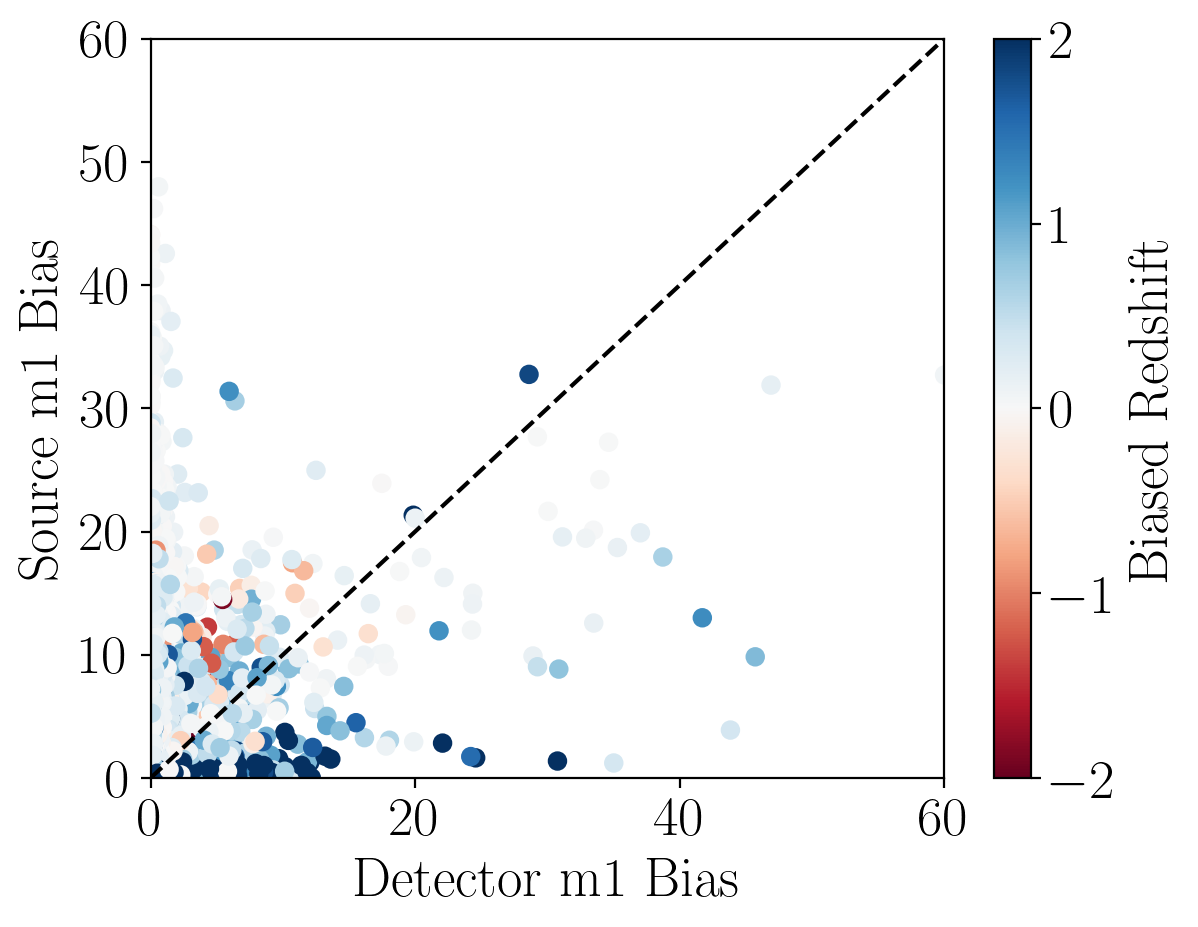

In [52]:
sc = plt.scatter(np.abs(df["m1_bias"]/df["m1_err"]), np.abs(df["m1_src_bias"]/df["m1_src_err"]), c=(df["z"]+df["z_bias"]), cmap="RdBu", vmin=-2, vmax=2)
cbar = plt.colorbar(sc)
cbar.set_label("Biased Redshift")
plt.xlabel("Detector m1 Bias")
plt.ylabel("Source m1 Bias")

x = np.linspace(0, 60, 10)
plt.plot(x,x, color='k', ls='--')
plt.xlim(0, 60)
plt.ylim(0, 60)

plt.show()

The overall similarity of the source frame and detector frame biases comes from the bi-directionality of the redshift bias.

When redshift is biased in the negative direction, such that the biased redshift becomes negative, the source frame mass is more biased compared to the detector frame mass. This usually correlates with $i \approx \pi/2$. 

When redshift is biased in the positive direction, the detector frame mass is more biased than the source frame mass.

These two effects compete, so that the overall result of including redshift is cancelled out.

Explanation for $- \Delta z \rightarrow$ source frame bias > detector frame bias:

When the redshift bias is $<0$, the biased $z$ tends to negative, which is unphysical. In these cases, we set the biased $z$ to 0 such that the $m_{1, \rm src}$ bias is approximately equal to the $m_{1, \rm det}$ bias.  Nevertheless, the measurement uncertainty in $m_{1, \rm src}$ becomes smaller by the addition of the $1/(1+z)$ factors to the covariance matrix (see equations). So the bias is more significant.

Explanation for $+ \Delta z \rightarrow$ source frame bias < detector frame bias:

When the redshift bias is $> 0$, there is a non-zero contribution to the $m_{1, \rm src}$ bias from $z$. This effect needs to compete with the $\mathcal{M}_c$ and $\eta$ bias, and so the total bias can be smaller OR larger than the detector mass bias in non-trivial ways. 

The measurement uncertainties are still smaller than the detector frame masses. The overall effect is mixed, with most biases being smaller than the detector frame bias and a few being larger.

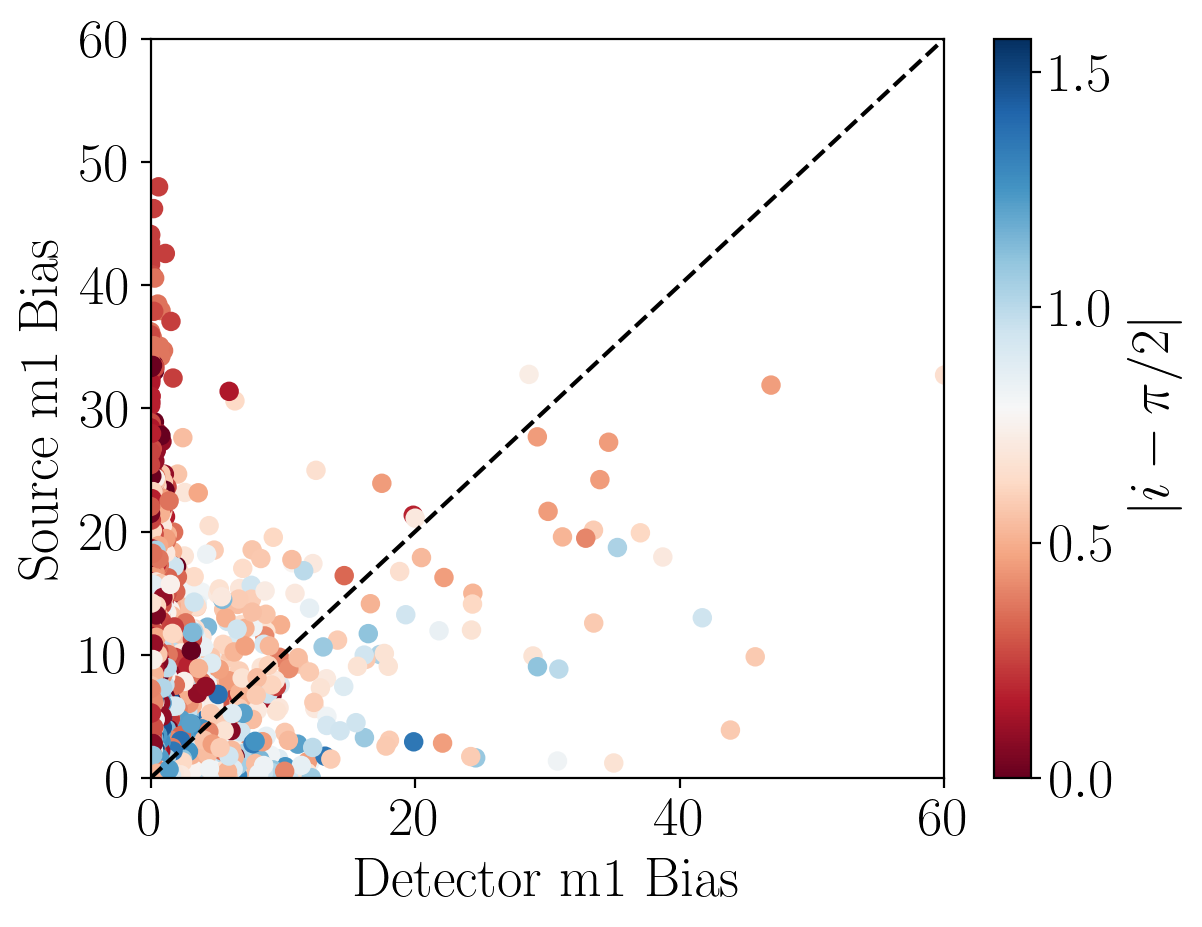

In [53]:
sc = plt.scatter(np.abs(df["m1_bias"]/df["m1_err"]), np.abs(df["m1_src_bias"]/df["m1_src_err"]), c=np.abs(df["iota"]-np.pi/2), cmap="RdBu", vmin=0, vmax=np.pi/2)
cbar = plt.colorbar(sc)
cbar.set_label("$|i-\pi/2|$")
plt.xlabel("Detector m1 Bias")
plt.ylabel("Source m1 Bias")

x = np.linspace(0, 60, 10)
plt.plot(x,x, color='k', ls='--')
plt.xlim(0, 60)
plt.ylim(0, 60)

plt.show()

# Compute $\chi_{eff}$

In [95]:
def chi_eff_from_df(df):
    chi1 = df["chi1z"]
    chi2 = df["chi2z"]
    m1 = df["m1"]
    m2 = df["m2"]

    chi_eff = (1/(m1+m2)) * (m1*chi1 + m2*chi2)

    chi1_biased = chi1 + df["chi1z_bias"]
    chi2_biased = chi2 + df["chi2z_bias"]
    m1_biased = m1 + df["m1_bias"]
    m2_biased = m2 + df["m2_bias"]

    chi_eff_biased = (1/(m1_biased+m2_biased)) * (m1_biased*chi1_biased + m2_biased*chi2_biased)
    chi_eff_bias = chi_eff_biased - chi_eff


    sigchi1 = df["chi1z_err"]
    sigchi2 = df["chi2z_err"]
    sigm1 = df["m1_err"]
    sigm2 = df["m2_err"]

    aux0=((((chi1-chi2)**2))*((m2**2)*(sigm1**2)))+((((chi1-chi2)**2))*((m1**2)*(sigm2**2)))
    aux1=((m1**2)*((((m1+m2)**2))*(sigchi1**2)))+(((m2**2)*((((m1+m2)**2))*(sigchi2**2)))+aux0)

    chi_eff_err = np.sqrt((((m1+m2)**-4.)*aux1))

    return chi_eff, chi_eff_bias, chi_eff_err


def chi_eff_src_from_df(df):
    chi1 = df["chi1z"]
    chi2 = df["chi2z"]
    m1 = df["m1_src"]
    m2 = df["m2_src"]

    chi_eff = (1/(m1+m2)) * (m1*chi1 + m2*chi2)

    chi1_biased = chi1 + df["chi1z_bias"]
    chi2_biased = chi2 + df["chi2z_bias"]
    
    m1_biased = m1 + df["m1_src_bias"]
    m2_biased = m2 + df["m2_src_bias"]

    chi_eff_biased = (1/(m1_biased+m2_biased)) * (m1_biased*chi1_biased + m2_biased*chi2_biased)
    chi_eff_bias = chi_eff_biased - chi_eff


    sigchi1 = df["chi1z_err"]
    sigchi2 = df["chi2z_err"]
    sigm1 = df["m1_src_err"]
    sigm2 = df["m2_src_err"]

    aux0=((((chi1-chi2)**2))*((m2**2)*(sigm1**2)))+((((chi1-chi2)**2))*((m1**2)*(sigm2**2)))
    aux1=((m1**2)*((((m1+m2)**2))*(sigchi1**2)))+(((m2**2)*((((m1+m2)**2))*(sigchi2**2)))+aux0)

    chi_eff_err = np.sqrt((((m1+m2)**-4.)*aux1))

    return chi_eff, chi_eff_bias, chi_eff_err

In [96]:
df["chi_eff"], df["chi_eff_bias"], df["chi_eff_err"] = chi_eff_src_from_df(df)
df = df.dropna()

# Hybr Features

In [88]:
labels = {
    'Mc': '$\mathcal{M}_c$',
    'eta': '$\eta$',
    'chi1z': '$\chi_{1,\\rm z}$',
    'chi2z': '$\chi_{2, \\rm z}$',
    'DL': 'DL',
    'z': '$z$',
    'm1': '$m_1$',
    'm2': '$m_2$',
    'm1_src': '$m_{1, \\rm src}$',
    'm2_src': '$m_{2, \\rm src}$',
    'chi_eff': '$\chi_{\\rm eff}$',
    'ra': 'ra',
    'dec': 'dec',
    'psi': 'psi',
    'iota': 'iota'
}

In [89]:
def plot_avg_vs_hybr(ax, df, quantity, x_qty="hybr", label="", **kwargs):
    hybrs = np.unique(df["hybr"])
    avg_qty = np.zeros_like(hybrs)
    x_data = np.zeros_like(hybrs)
    
    for i, hybr in enumerate(hybrs):
        mask = (df["hybr"]==hybr)
        avg_qty[i] = np.average(quantity[mask])
        x_data[i] = np.average(df[mask][x_qty])

    ax.plot(x_data, avg_qty, label=label, **kwargs)


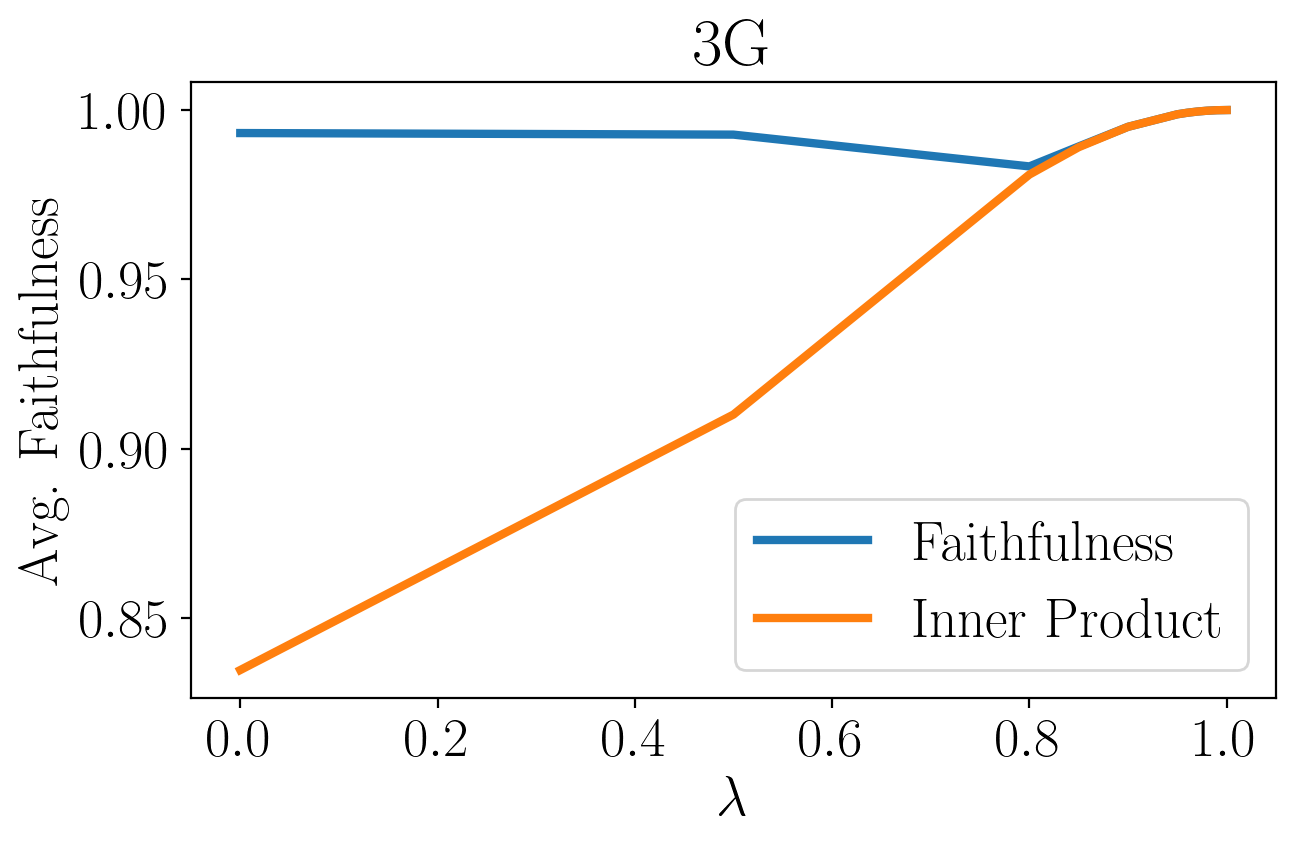

In [90]:
fig, ax = plt.subplots(figsize=(7, 4))


plot_avg_vs_hybr(ax, df, df["faith"], label="Faithfulness", lw=3)
plot_avg_vs_hybr(ax, df, df["inner_prod"], label="Inner Product", lw=3)

ax.set_xlabel("$\lambda$")
ax.set_ylabel("Avg. Faithfulness")

# plt.loglog()
plt.title('3G')
plt.legend()
plt.show()

In [91]:
def bias_avg_var_plot(df, ax, hybrs=np.linspace(0.0, 1.0, 1), x_qty="hybr", xlabel='$\lambda$', title='', vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL'],
                    legend_loc='upper right', snr_lim = None, labels=None, **kwargs):

    if snr_lim is not None:
        df = df[df["snr"]>snr_lim]
    
    for var in vars:
        x_data = np.zeros_like(hybrs)
        avg_qty = np.zeros_like(hybrs)
        x_data = np.zeros_like(hybrs)
        
        for i, hybr in enumerate(hybrs):
            mask = (df["hybr"]==hybr)
            df_hybr = df[mask]
            quantity = np.abs(df_hybr[f"{var}_bias"]/df_hybr[f"{var}_err"])
            avg_qty[i] = np.average(quantity)
            x_data[i] = np.average(df_hybr[x_qty])

        if labels is None:
            ax.plot(x_data, avg_qty, **kwargs)
        else:
            ax.plot(x_data, avg_qty, label=labels[var], **kwargs)
        

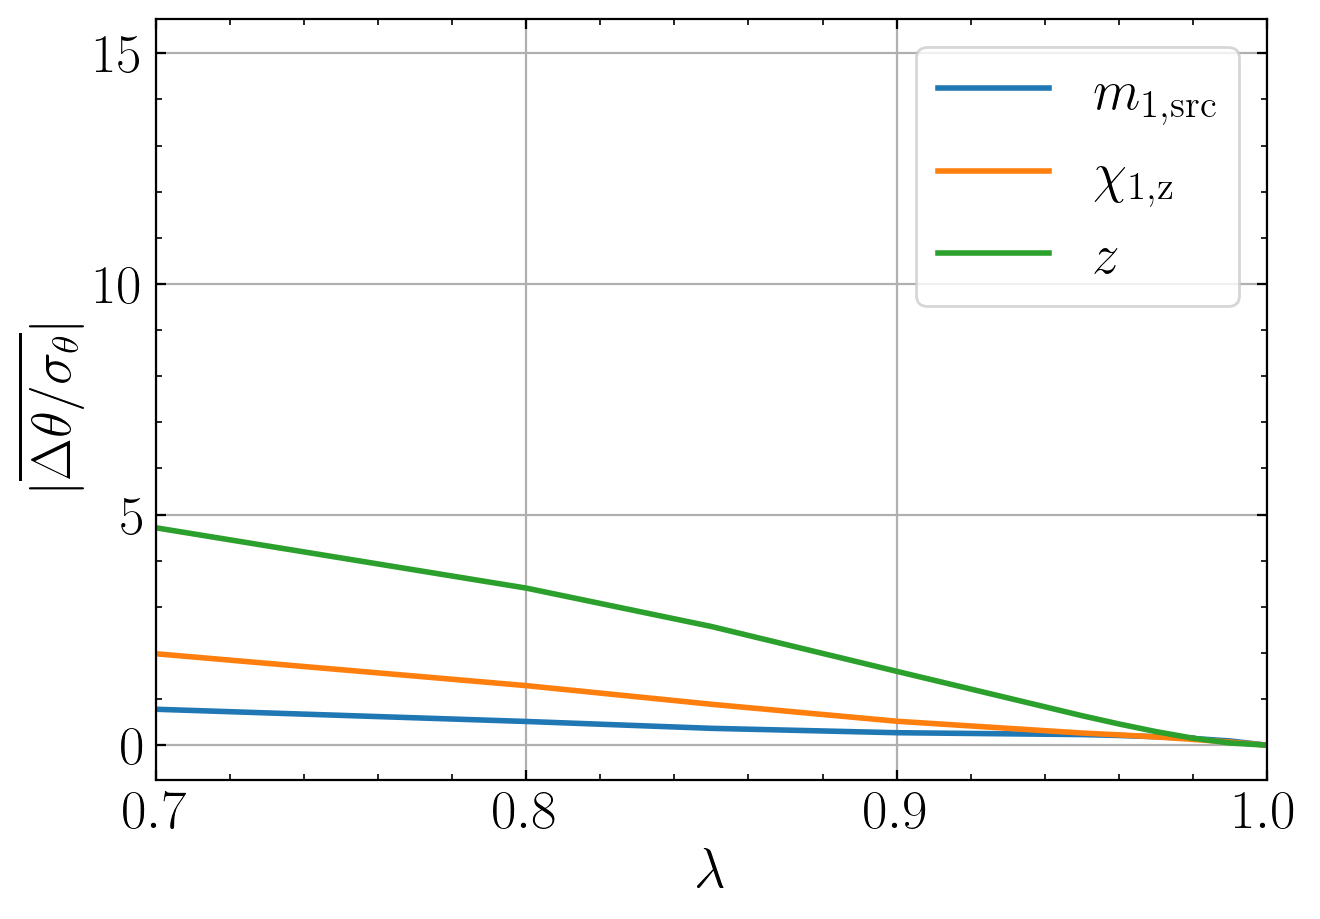

In [92]:
hybrs = np.unique(df["hybr"])

# vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi_eff', 'DL']
vars = ['m1_src', 'chi1z', 'z']

# vars = ["Mc"]




snr_lim=10

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))


#
bias_avg_var_plot(df, ax, hybrs[:9], vars=vars, title='3G', labels=None, snr_lim=snr_lim,
                lw=2, linestyle='-')
ax.set_prop_cycle(None)
bias_avg_var_plot(df, ax, hybrs[8:], vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
                lw=2)

ax.set_xlim(0.7, 1.0)
# ax.set_ylim(0, 5)


ax.set_xlabel("$\lambda$")
ax.set_ylabel("$|\overline{\Delta \\theta/\sigma_{\\theta}}|$")

plt.legend(loc='upper right')

plt.grid(which='major')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', tick2On=True)

plt.tight_layout()
# plt.savefig('1D_bias_plots/3g_pop_bias_sig_vs_lambda.pdf', dpi=300)

plt.show()

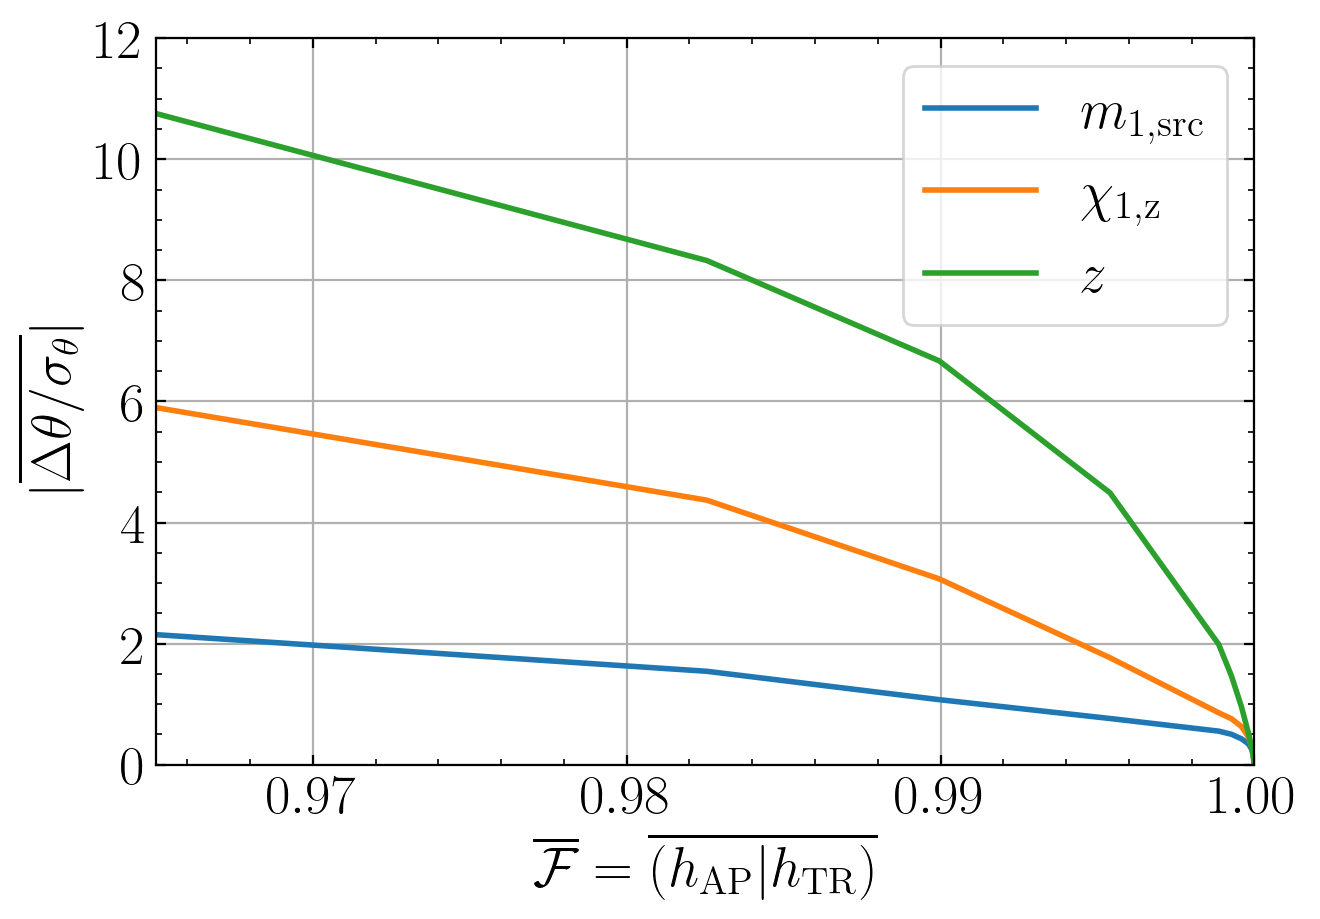

In [112]:
hybrs = np.unique(df["hybr"])

# vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'z']
# vars = ['m1', 'm1_src', 'z']
vars = ['m1_src', 'chi1z', 'z']

# vars = ["Mc"]

snr_lim=50
n_sigma = 2
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))


bias_avg_var_plot(df, ax, hybrs[:9], x_qty="inner_prod", vars=vars, title='3G', labels=None, snr_lim=snr_lim,
                lw=2, linestyle='-')
ax.set_prop_cycle(None)
bias_avg_var_plot(df, ax, hybrs[8:], x_qty="inner_prod", vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
                lw=2)



ax.set_xlabel("$\overline{\mathcal{F}} = \overline{(h_{\\rm AP} | h_{\\rm TR})}$")
ax.set_ylabel("$|\overline{\Delta \\theta/\sigma_{\\theta}}|$")

plt.legend(loc='upper right')

plt.grid(which='major')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', tick2On=True)

ax.set_ylim(0, 12)
ax.set_xlim(0.965, 1.0)

plt.tight_layout()
# plt.savefig('1D_bias_plots/3g_pop_bias_sig_vs_inner_prod.pdf', dpi=300)

plt.show()

## see a few individual examples

In [94]:
def plot_index_vs_hybr(ax, df, quantity, indices = [1,2,3,4,5], label="", **kwargs):

    for index in indices:
        mask_index = (df["index"]==index)
        hybrs = np.unique(df["hybr"])
        qty = np.zeros_like(hybrs)
        
        for i, hybr in enumerate(hybrs):
            mask_hybr = (df["hybr"]==hybr)
            qty[i] = quantity[mask_index*mask_hybr].values[0]

        ax.plot(hybrs, qty, label=index, **kwargs)

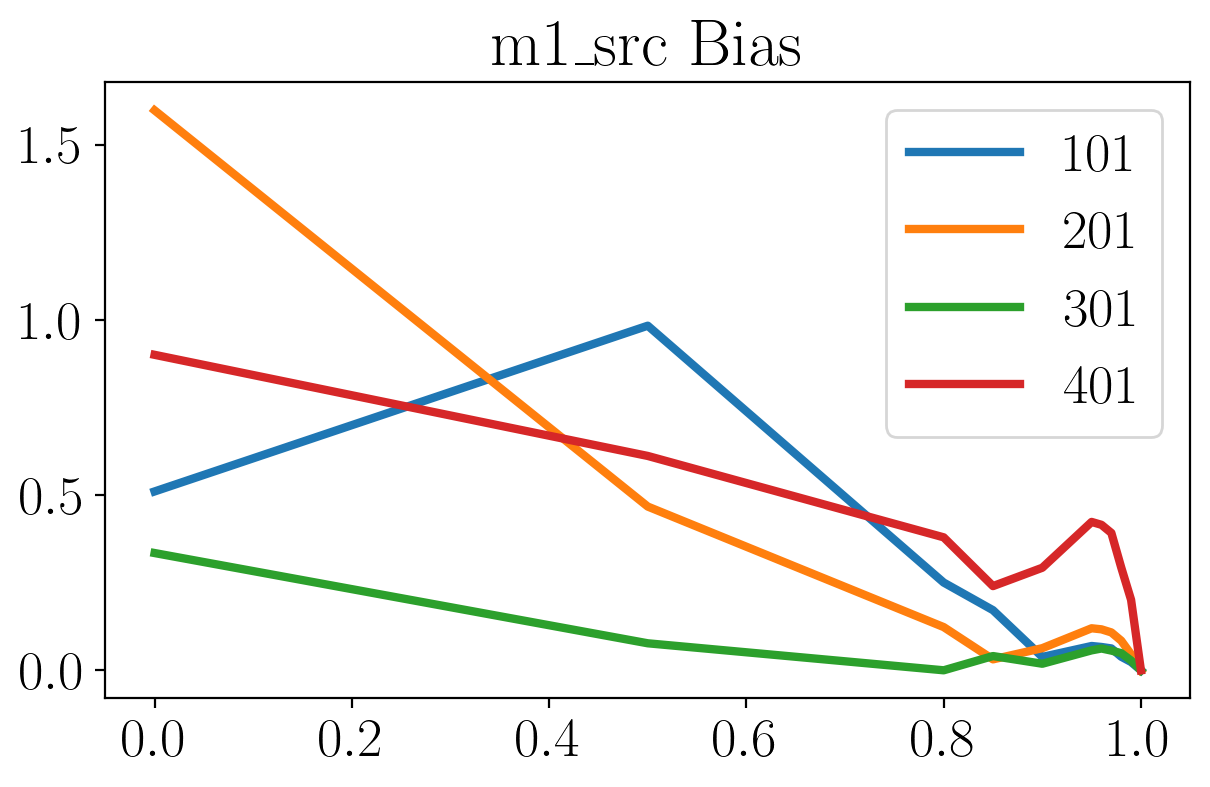

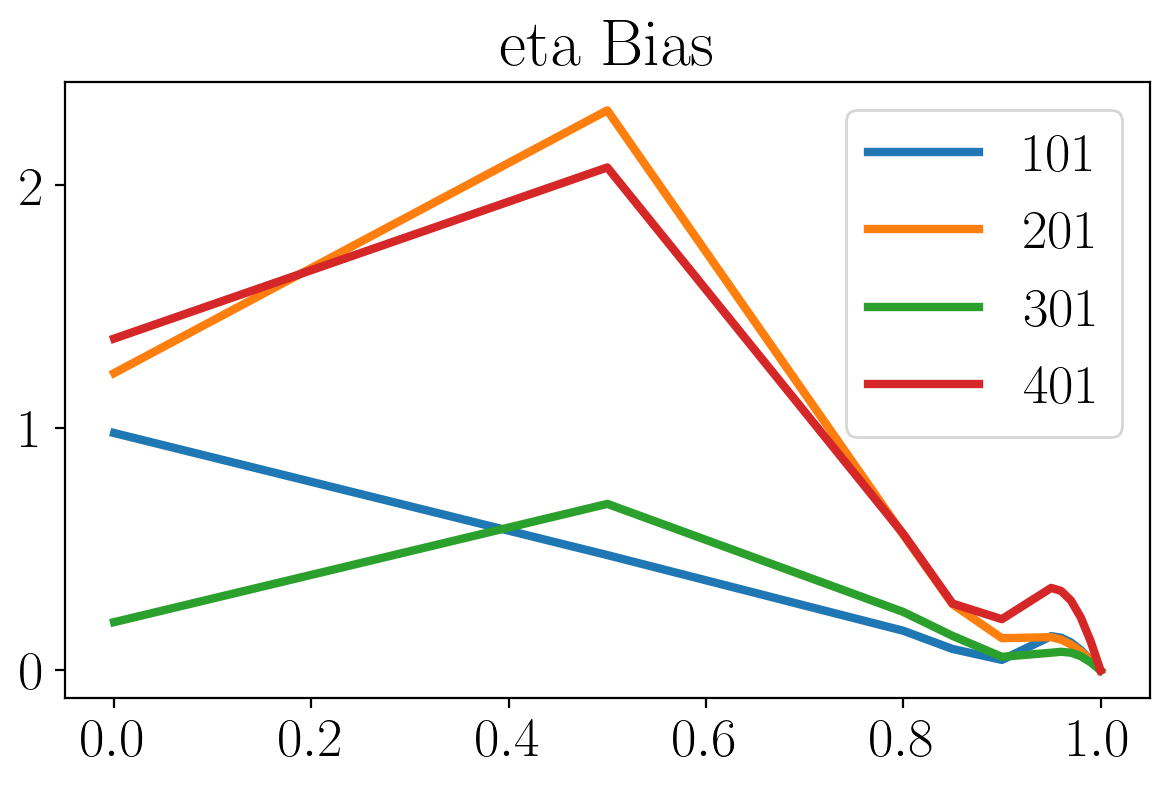

In [95]:
fig, ax = plt.subplots(figsize=(7, 4))
plot_index_vs_hybr(ax, df, quantity=np.abs(df["m1_src_bias"]/df["m1_src_err"]), indices=[101,201,301,401], label="$\mathcal{M}_c$",lw=3)
plt.title("m1_src Bias")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
plot_index_vs_hybr(ax, df, quantity=np.abs(df["eta_bias"]/df["eta_err"]), indices=[101,201,301,401], label="$\mathcal{M}_c$",lw=3)
plt.title("eta Bias")
plt.legend()
plt.show()

## % of Biased events from Total Population

In [96]:
def bias_perc_plot(df, ax, hybrs, n_sigma=1.0, x_qty="hybr", xlabel='$\lambda$', title='', vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL'], snr_factor = 1.0,
                    legend_loc='upper right', snr_lim = None, labels=None, **kwargs):

    snr_cut_str = " "
    if snr_lim is not None:
        df = df[df["snr"]>snr_lim]
        snr_cut_str = f"SNR>{snr_lim:.1f}"
    

    for var in vars:
        x_data = np.zeros_like(hybrs)
        bias_perc = np.zeros_like(hybrs)
        for i, hybr in enumerate(hybrs):
            df_hybr = df[df["hybr"]==hybr]
            x_data[i] = np.average(df_hybr[x_qty])

            data = snr_factor* df_hybr[f"{var}_bias"]/df_hybr[f"{var}_err"]
            bias_perc[i] = 100* np.sum(np.abs(data)>n_sigma) / len(data)
        
        if labels is None:
            ax.plot(x_data, bias_perc, **kwargs)
        else:
            ax.plot(x_data, bias_perc, label=labels[var], **kwargs)
        

    ax.set_xlabel(xlabel)
    # ax.set_ylabel(f"Biased Events (%)")
    # ax.set_title(f"{title} Bias Percentage ($\geq${n_sigma}$\sigma$)")

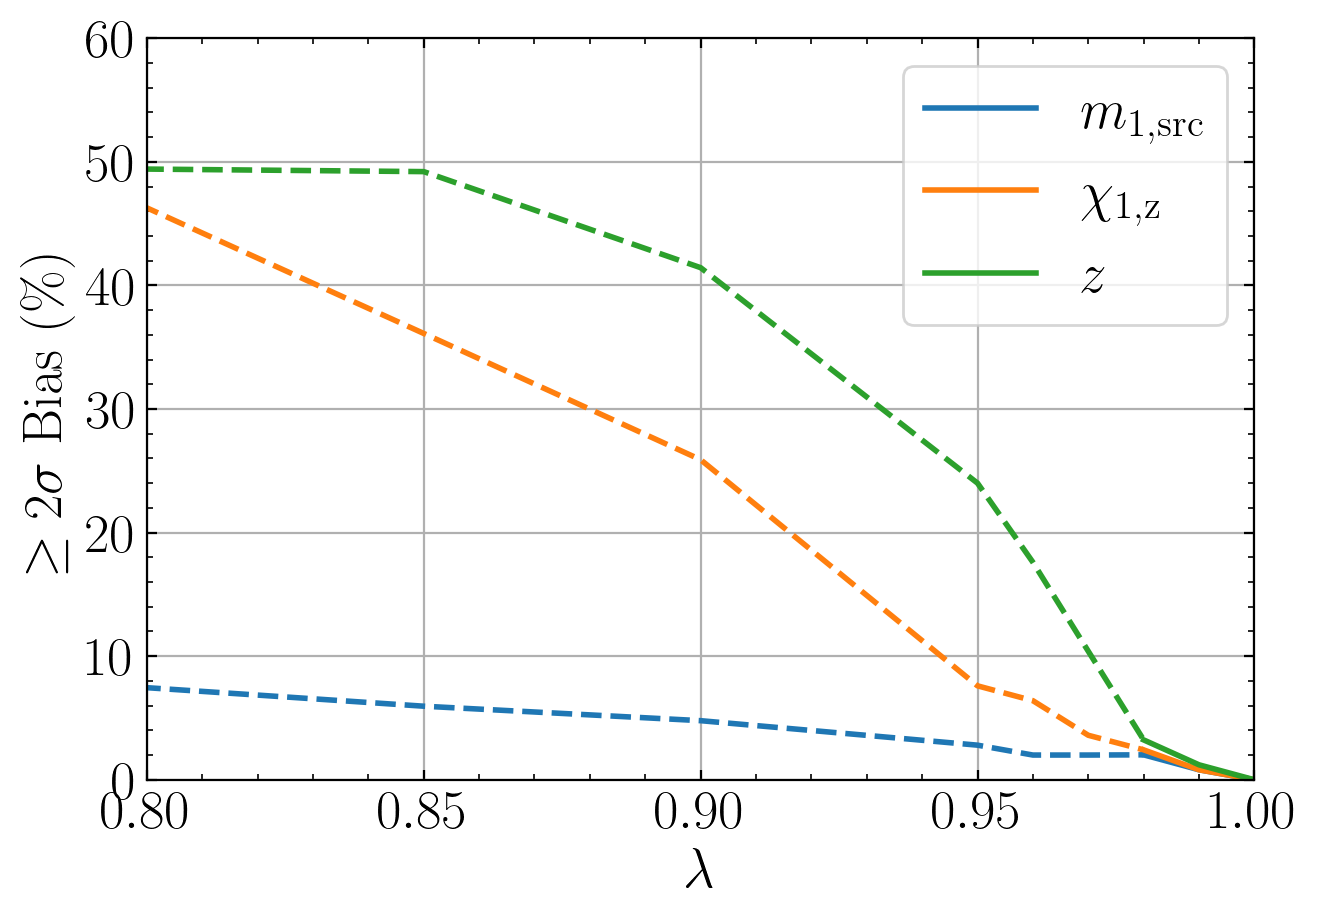

In [113]:
hybrs = np.unique(df["hybr"])

# vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi_eff', 'DL']
vars = ['m1_src', 'chi1z', 'z']

# vars = ["Mc"]




snr_lim= 50
n_sigma = 2
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))


# bias_perc_plot(df, ax, hybrs, n_sigma=n_sigma, vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
#                 lw=2)

bias_perc_plot(df, ax, hybrs[:9], n_sigma=n_sigma, vars=vars, title='3G', labels=None, snr_lim=snr_lim,
                lw=2, linestyle='--')
ax.set_prop_cycle(None)
bias_perc_plot(df, ax, hybrs[8:], n_sigma=n_sigma, vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
                lw=2)

ax.set_ylim(0, 60)
ax.set_xlim(0.8, 1.0)
# ax.set_xscale('log')

ax.set_ylabel('$\geq 2\sigma$ Bias (\%)')
ax.set_xlabel("$\lambda$")

plt.legend(loc='upper right')

plt.grid(which='major')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', tick2On=True)



plt.tight_layout()
# plt.savefig('1D_bias_plots/3g_pop_percentage_vs_lambda.pdf', dpi=300)

plt.show()

## Bias % vs Average Mismatch

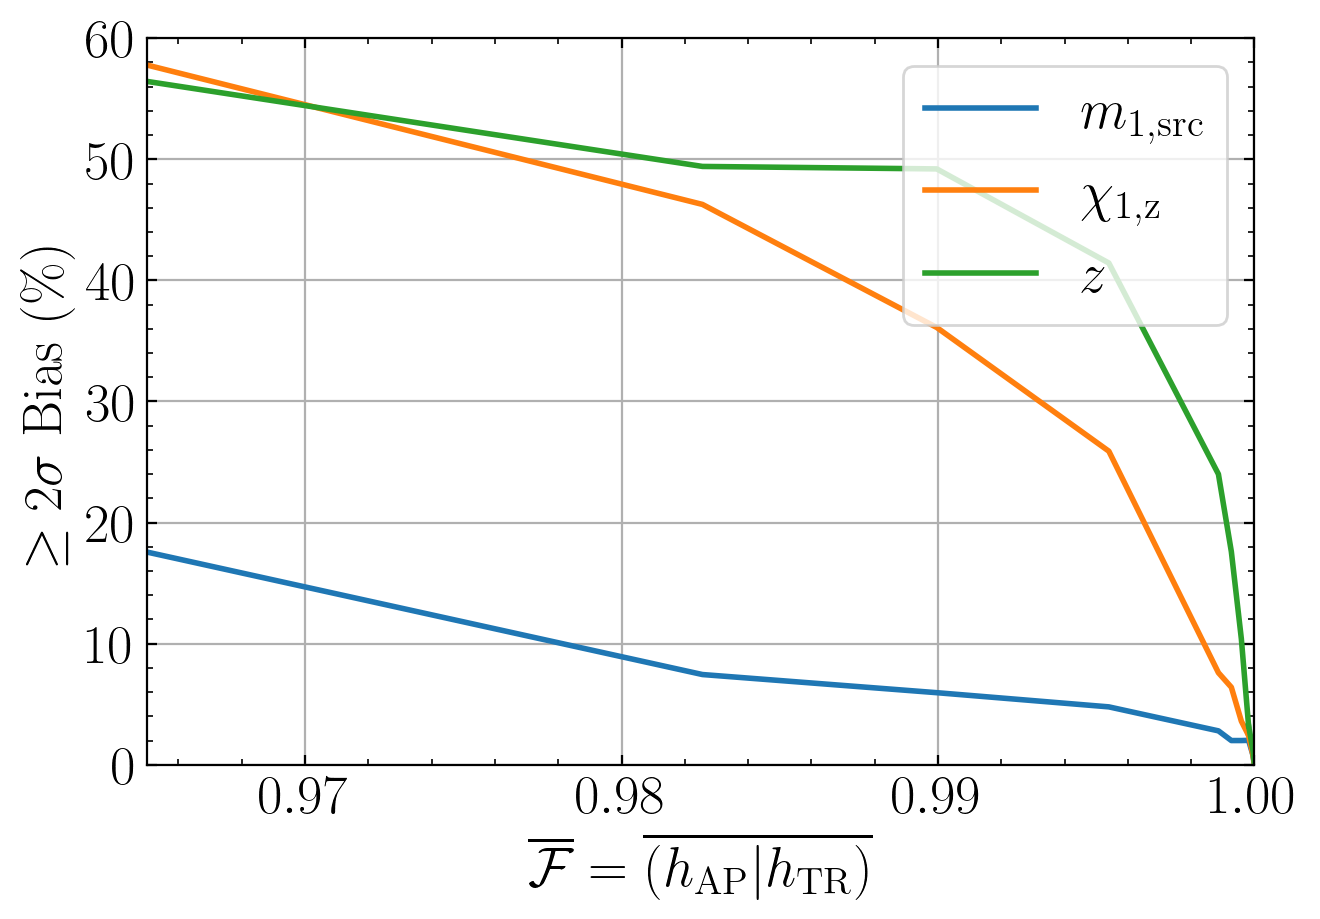

In [114]:
hybrs = np.unique(df["hybr"])

# vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi_eff', 'DL']
vars = ['m1_src', 'chi1z', 'z']

# vars = ["Mc"]


snr_lim= 50
n_sigma = 2
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))

bias_perc_plot(df, ax, hybrs[:9], n_sigma=n_sigma, x_qty="inner_prod", xlabel="Avg Faithfulness", vars=vars, title='3G', labels=None, snr_lim=snr_lim,
                lw=2,linestyle='-')
ax.set_prop_cycle(None)
bias_perc_plot(df, ax, hybrs[8:], n_sigma=n_sigma, x_qty="inner_prod", xlabel="Avg Faithfulness", vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
                lw=2)

ax.set_ylim(0., 60.0)
ax.set_xlim(0.965, 1.0)

ax.set_ylabel(f'$\geq {n_sigma}\sigma$ Bias (\%)')
ax.set_xlabel("$\overline{\mathcal{F}} = \overline{(h_{\\rm AP} | h_{\\rm TR})}$")


plt.legend(loc='upper right')

plt.grid(which='major')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', tick2On=True)

plt.tight_layout()

# plt.savefig('1D_bias_plots/3g_pop_percentage_vs_inner_prod.pdf', dpi=300)
plt.show()

# Population Distribution

In [115]:
from scipy import interpolate, integrate

def power(m1, alpha, m_min, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1:
        N1 = 1 / ((m_max**(alpha+1) - m_min**(alpha+1))/(alpha+1))
    else:
        N1 = 1/(np.log(m_max/m_min))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, 0])

def butterworth(m1, m0, eta):
    norm = integrate.trapezoid((1+ (m0/m1)**eta)**(-1), m1)

    return (1+ (m0/m1)**eta)**(-1) / norm

def truncation(m1, m_min, m_max):
    return np.piecewise(m1, [(m1 < m_max), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, 1.0, 0])

def beta(chi, a, b):
    func = chi**(a-1) * (1-chi)**(b-1)
    norm = integrate.trapezoid(func, chi)
    return func/norm

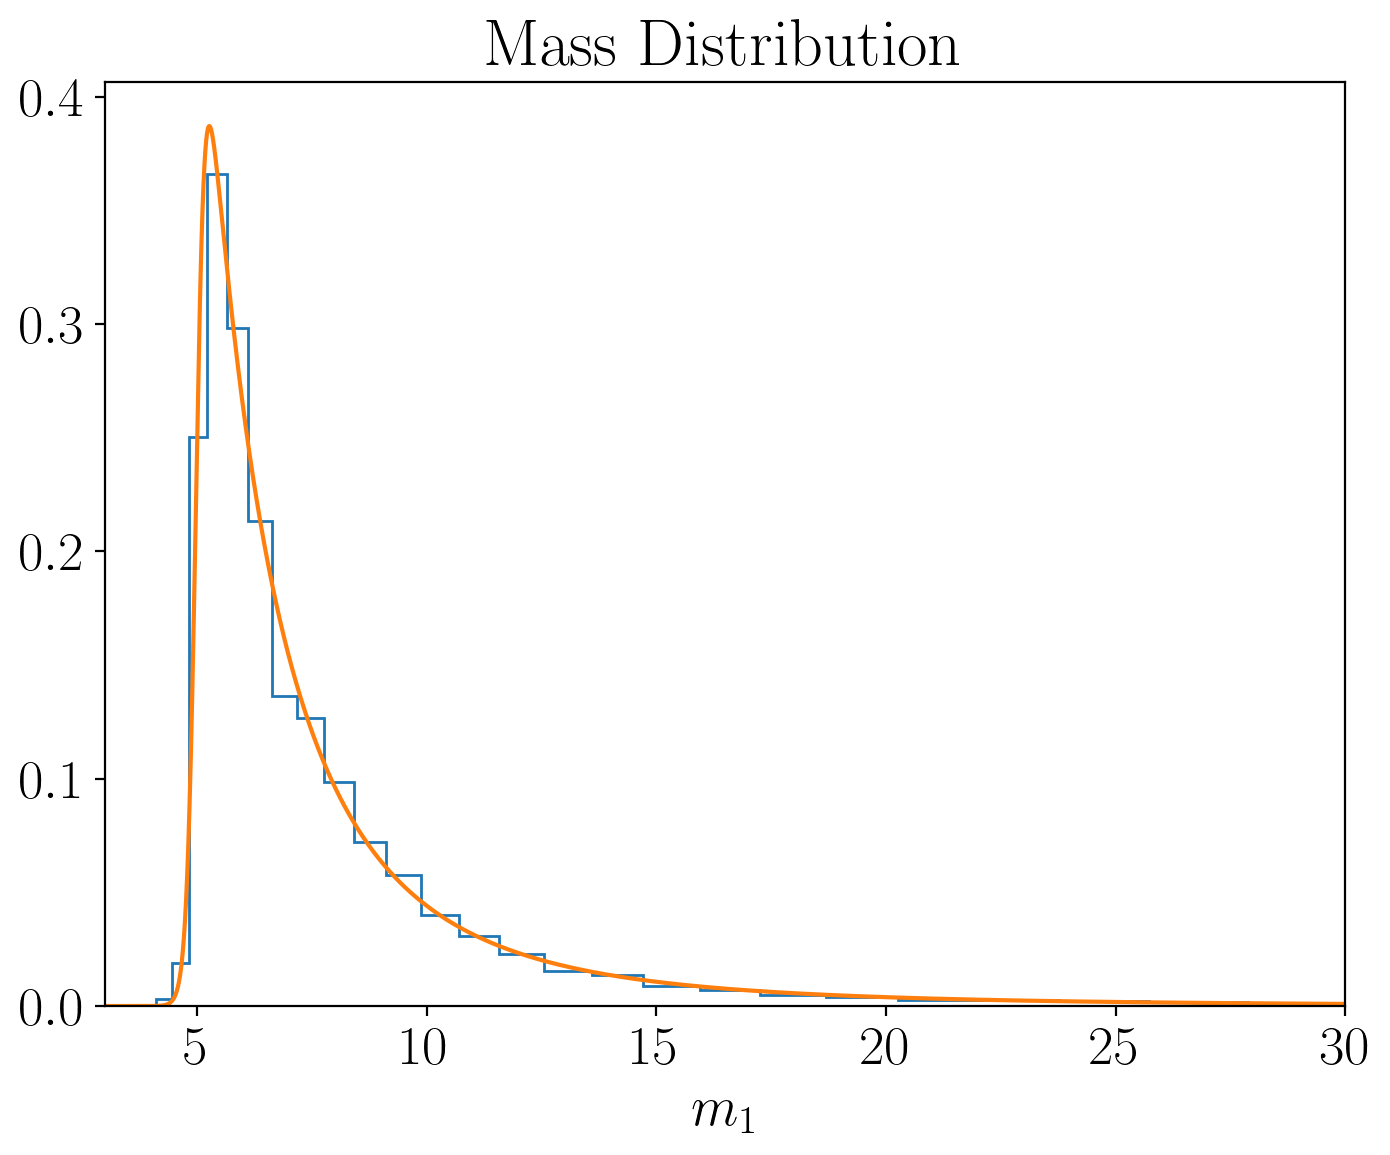

In [116]:
# Mass Distribution
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.geomspace(2, 100, 50)

plt.hist(df["m1_src"], bins=bins, histtype='step', density=True)

m1 = np.geomspace(2, 100, 100000)
pdf_m1 = butterworth(m1, 5, 50) * power(m1, -3.5, 3, 60)
pdf_m1 = pdf_m1/integrate.trapezoid(pdf_m1, m1)
plt.plot(m1, pdf_m1)

plt.xlim(3, 30)

plt.xlabel("$m_1$")
plt.ylabel("")
# plt.legend(loc='upper right')
plt.title("Mass Distribution")

plt.show()

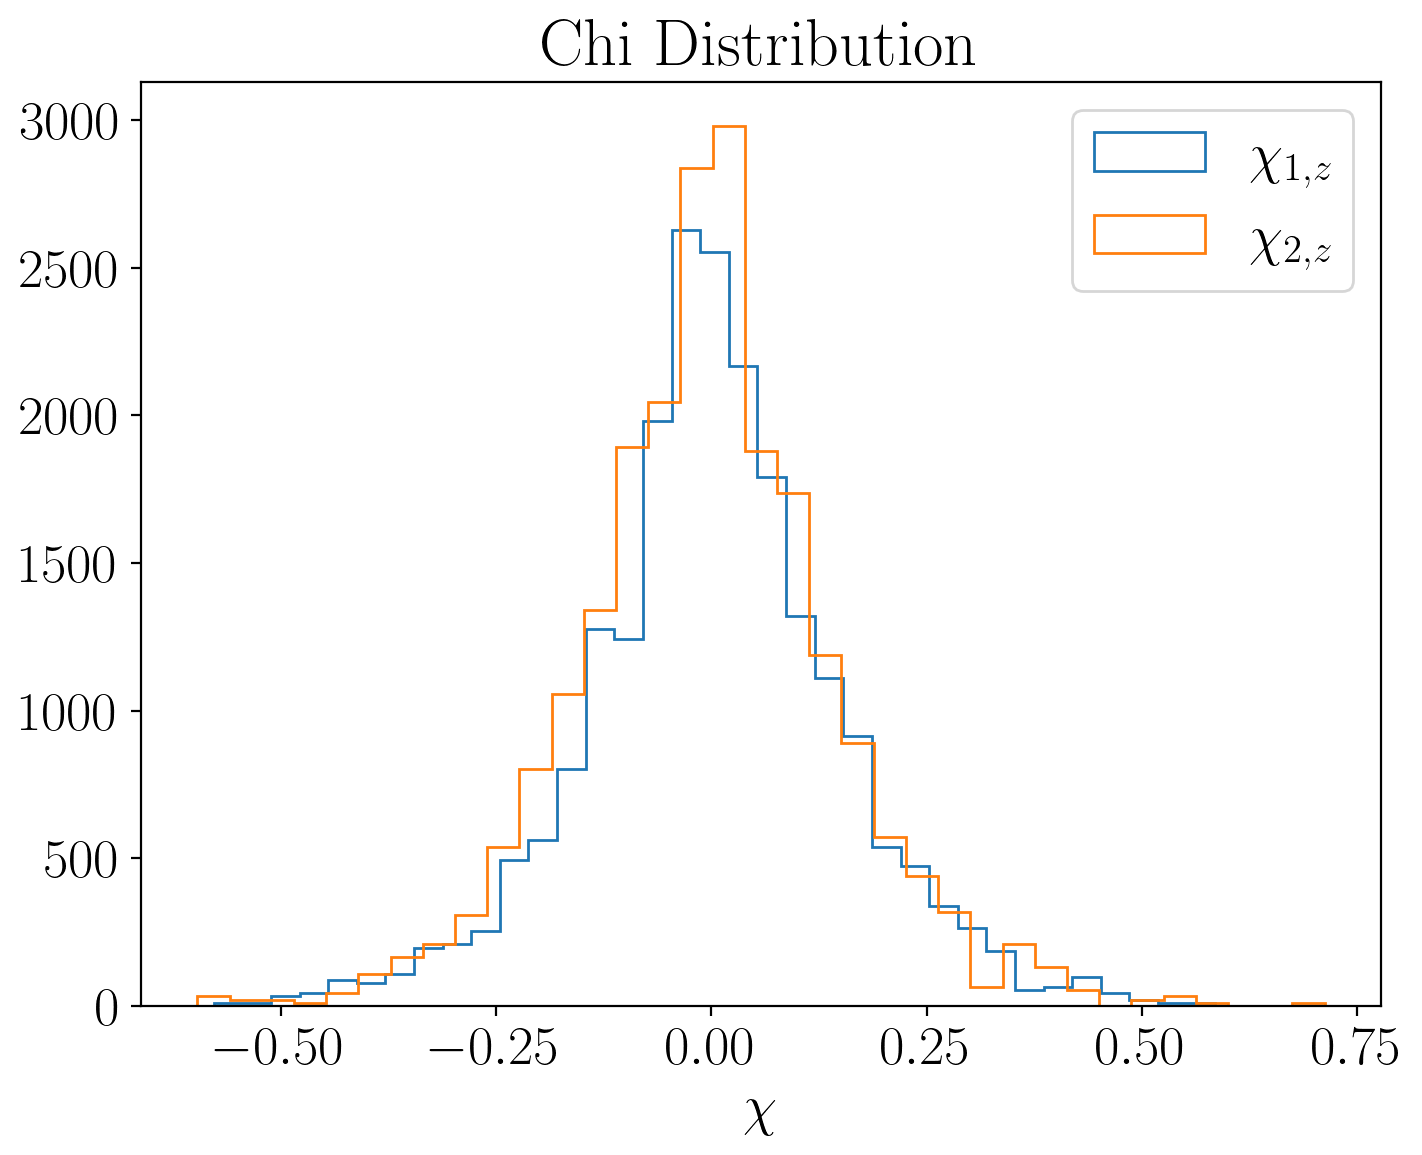

In [117]:
# Chi Distribution
fig, ax = plt.subplots(figsize=(8, 6))

chi_range = np.linspace(0, 1, 100000)
a = 2
b = 7
pdf_chi = beta(chi_range, a, b)
# plt.plot(chi_range, pdf_chi)

bins = np.linspace(-1, 1, 50)
plt.hist(df["chi1z"], bins=35, histtype='step', label="$\chi_{1,z}$")
plt.hist(df["chi2z"], bins=35, histtype='step', label="$\chi_{2,z}$")

# costheta = np.random.uniform(low=-1.0, high=1.0, size=len(df))
# plt.hist(df["chi1z"]/costheta, bins=bins, histtype='step', label="$\chi_{1,z}$", density=True)
# plt.hist(df["chi2z"]/costheta, bins=bins, histtype='step', label="$\chi_{2,z}$", density=True)


# plt.xlim(0, 1)
plt.xlabel("$\chi$")
plt.ylabel("")
plt.legend(loc='upper right')
plt.title("Chi Distribution")

plt.show()

# Relative Bias Histograms

In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [102]:
def bias_hist_plot(df, ax, hybr='0.9', title='', vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL'], n_sigma=2.0, snr_factor = 1.0,
                    bins=30, legend_loc='upper right', snr_lim = None ,kde=False, labels=None, **kwargs):
    mask = (df['hybr']==hybr)

    snr_cut_str = " "
    if snr_lim is not None:
        mask = mask*(df["snr"]>snr_lim)
        snr_cut_str = f"SNR>{snr_lim:.1f}"
    
    df = df[mask]

    for var in vars:
        data = snr_factor* df[f"{var}_bias"]/df[f"{var}_err"]
        bias_perc = 100* np.sum(np.abs(data)>n_sigma) / len(data)
        if labels is None:
            label=var + f" ({bias_perc:.1f}\% biased)"
        else:
            label = labels[var] + f" ({bias_perc:.1f}\% biased)"
        if not kde:
            ax.hist(data, bins=bins, histtype='step', label=label, **kwargs)
        else:
            sns.kdeplot(data=data, ax=ax, bw_adjust=1, gridsize=1000, label=label)

    # ax.set_xlabel("$\Delta \\theta / \sigma_{\\theta}$")
    # ax.set_title(title)
    ax.text(-9, 2.7, title, fontsize=20)
    faith = np.average(df["inner_prod"])

    ax.text(-9, 1.0, "$\mathcal{F}=$"+f"{faith:.3f}", fontsize=20)

    ax.legend(loc=legend_loc, fontsize=20)
    
    # ticks
    ax.tick_params(labelbottom=False, direction="in", which='major', length=5.0, width=1.0, top=True)



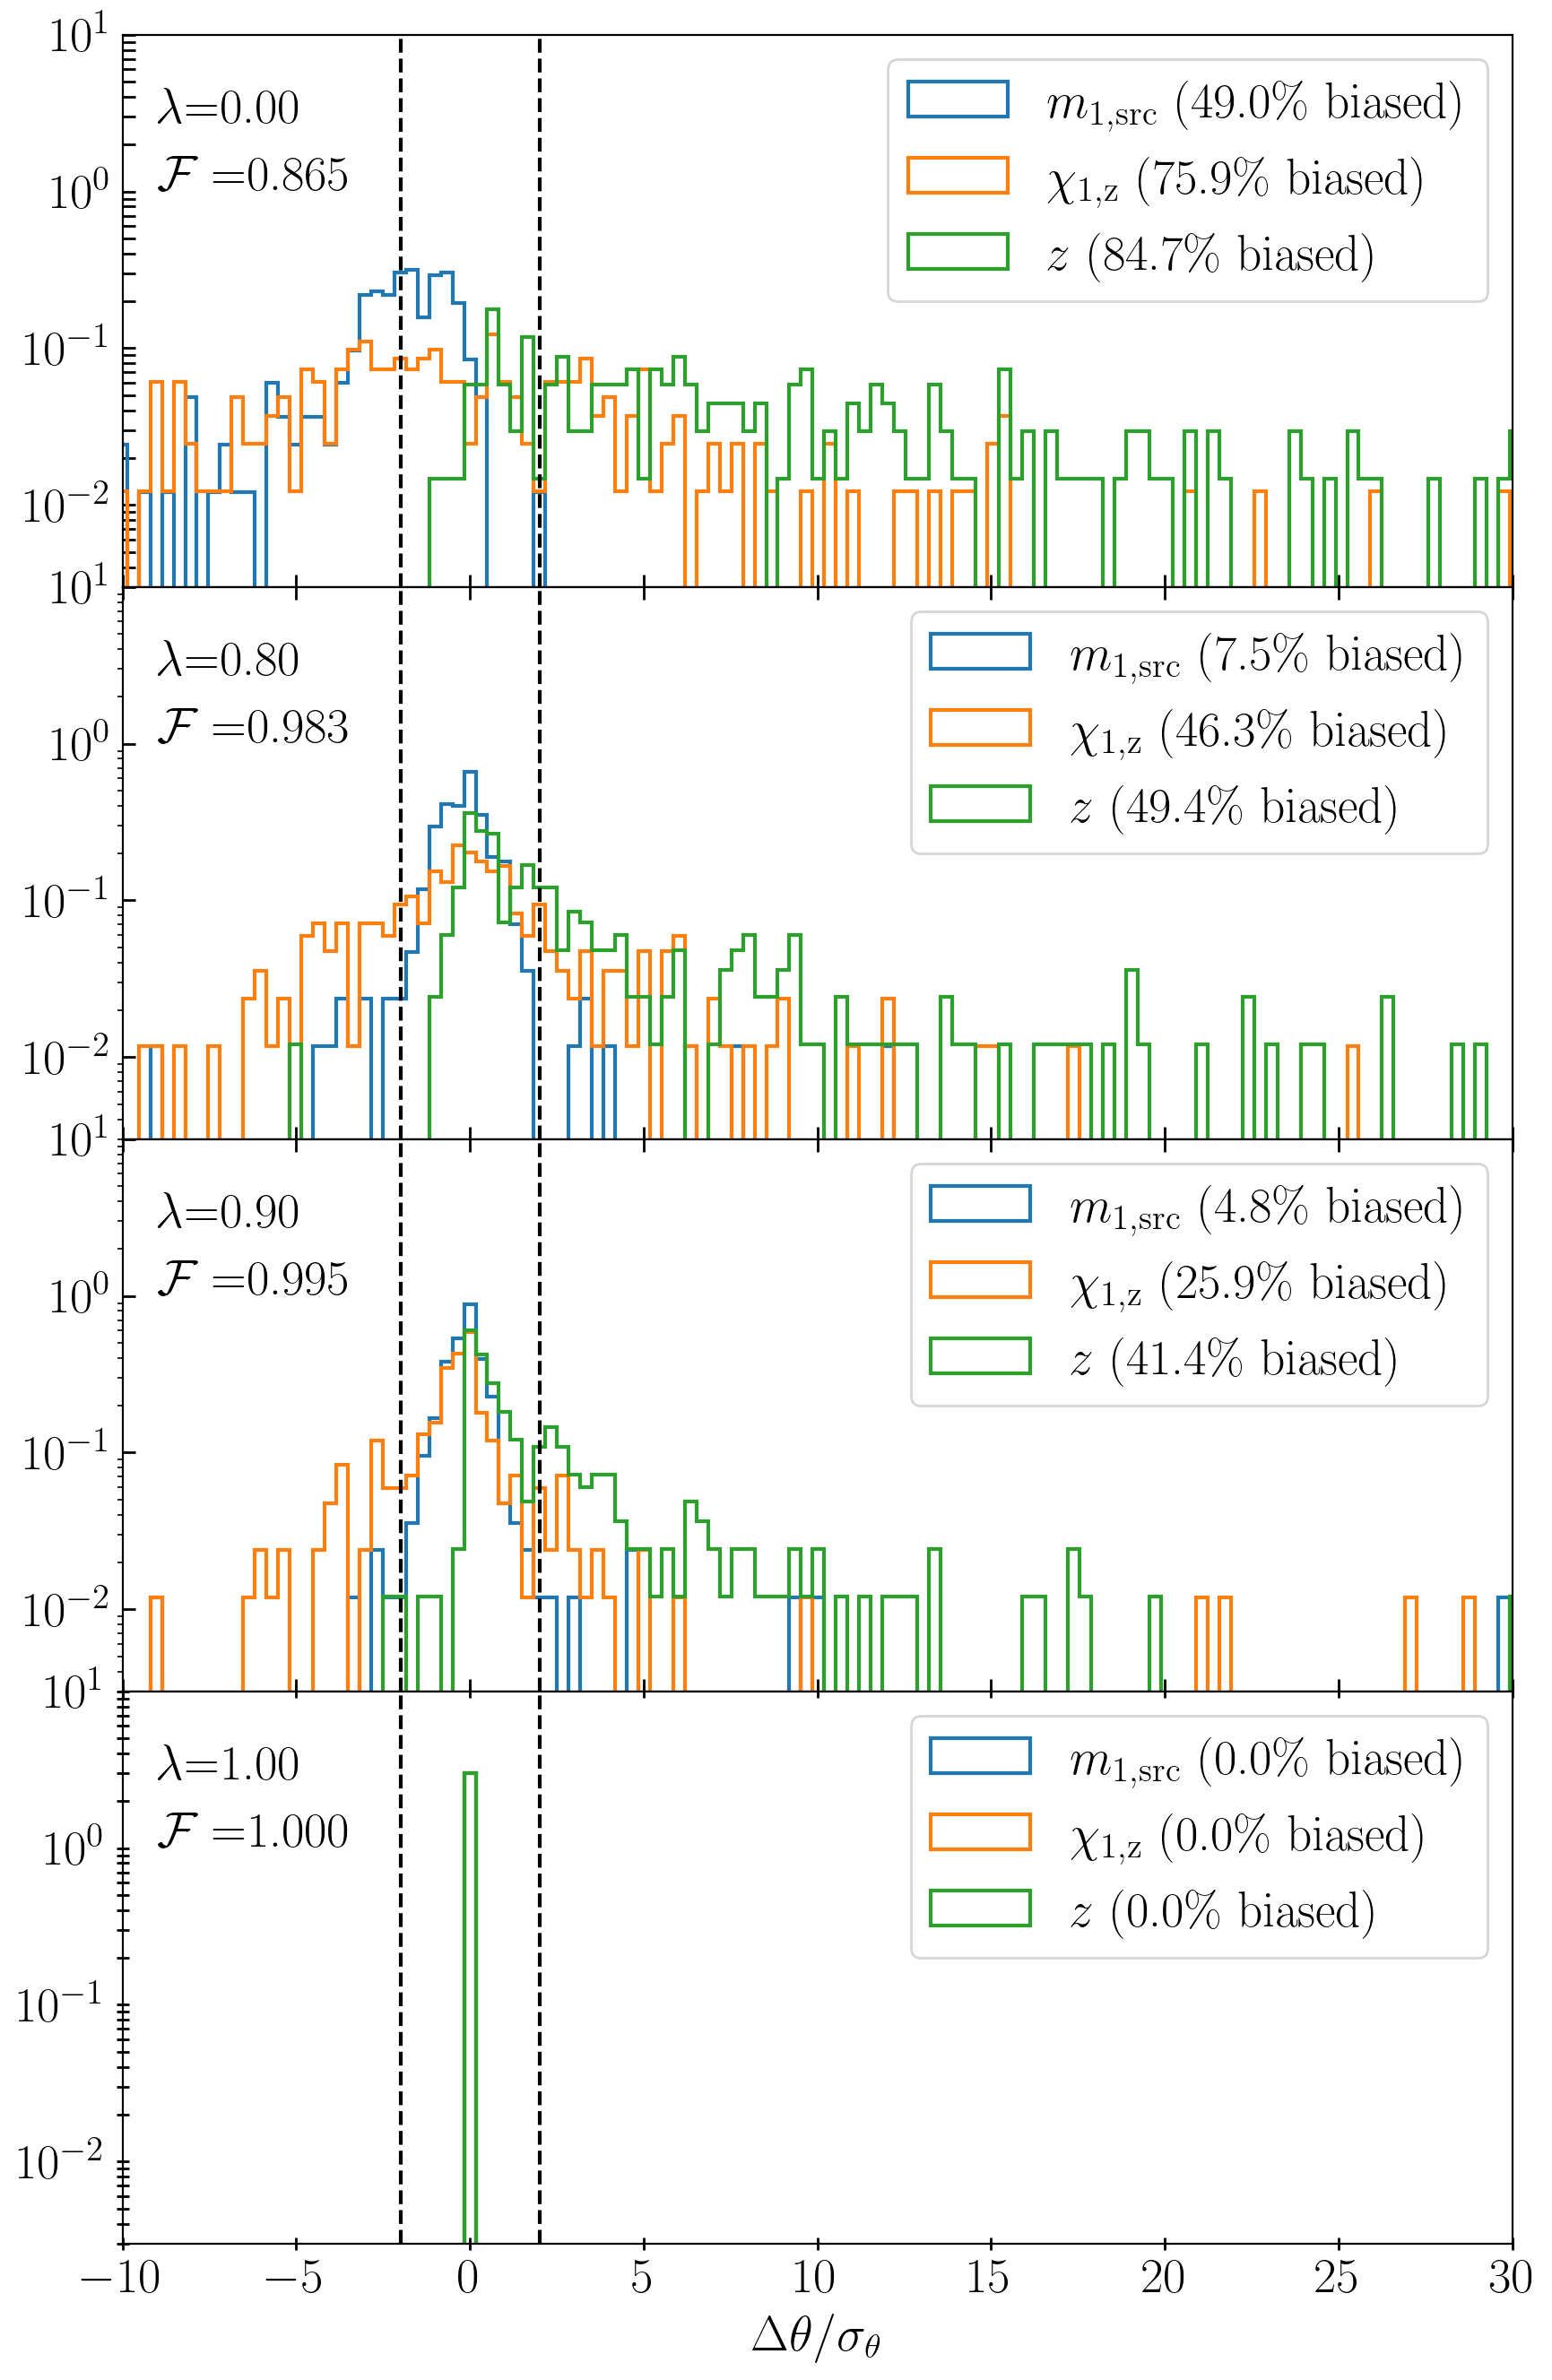

In [118]:
# hybrs = np.unique(df["hybr"])
hybrs = [0.0, 0.8, 0.9, 1.0]

fig, axes = plt.subplots(ncols=1, nrows=len(hybrs), sharex=True, figsize=(10, 4*len(hybrs)))

# vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi_eff', 'DL']
vars = ['m1_src', 'chi1z', 'z']



bins=np.linspace(-50, 50, 300)
# bins=30

snr_lim= 50

for i, hybr in enumerate(hybrs):
    bias_hist_plot(df, axes[i], hybr=hybr, title=f'$\lambda$={hybr:.2f}', n_sigma=2.0, vars=vars, bins=bins, labels=labels, snr_lim=snr_lim,
                lw=1.5, density=True, kde=False)

axes[0].tick_params(labelbottom=False, direction="in", which='both', length=5.0, width=1.0, top=False)
axes[-1].tick_params(labelbottom=True, direction="inout", length=5.0, width=1.0, which="both", top=True)


for ax in axes:
    ax.axvline(x=2, color='k', ls='--')
    ax.axvline(x=-2, color='k', ls='--')
    ax.set_xlim(-10, 30)
    ax.set_ylim(0.0, 3.5)
    ax.minorticks_off()
    ax.set_ylim(0.003, 10)
    ax.set_yscale('log')
    
plt.xlabel("$\Delta \\theta / \sigma_{\\theta}$")

plt.subplots_adjust(hspace=.0)


# plt.tight_layout()

# plt.savefig('1D_bias_plots/3g_pop_bias_histograms.pdf', dpi=300)

plt.show()